# 🚢 Titanic Survival Prediction
-This notebook builds an ensemble model (Logistic Regression + Random Forest + XGBoost) to predict Titanic passenger survival.  
-We also analyze **feature importance** to understand which factors mattered most.


# 1. Import Libraries

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


# 2. Load Data
-We use the Kaggle Titanic dataset.

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_passenger_ids = test["PassengerId"]

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 3. Preprocessing & Feature Engineering
- Handle missing values  
- Create Family features (`FamilySize`, `IsAlone`)  
- Extract `Title` from names  

In [8]:
def preprocess_data(df):
    df["Age"].fillna(df["Age"].median(), inplace=True)
    df["Fare"].fillna(df["Fare"].median(), inplace=True)
    df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

    df["Title"] = df["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
    df["Title"] = df["Title"].replace(
        ["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major",
         "Rev", "Sir", "Jonkheer", "Dona"], "Rare"
    )
    df["Title"] = df["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
    
    return df

train = preprocess_data(train)
test = preprocess_data(test)


## 4. Encoding Categorical Features
We use **LabelEncoder** to convert `Sex`, `Embarked`, and `Title` into numeric values.


In [9]:
le = LabelEncoder()
for col in ["Sex", "Embarked", "Title"]:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])


## 5. Drop Unnecessary Columns
Passenger IDs and textual columns that don't add value are removed.


In [10]:
drop_cols = ["PassengerId", "Name", "Ticket", "Cabin"]
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)


## 6. Train / Validation Split
We use 80% for training and 20% for validation.


In [11]:
X = train.drop("Survived", axis=1)
y = train["Survived"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## 7. Model Training (Ensemble)
We combine Logistic Regression, Random Forest, and XGBoost using a **Voting Classifier**.


In [12]:
lr = LogisticRegression(max_iter=1000, random_state=42)

rf = RandomForestClassifier(
    n_estimators=300, max_depth=6, min_samples_split=5,
    min_samples_leaf=2, random_state=42
)

xgb = XGBClassifier(
    n_estimators=500, learning_rate=0.01, max_depth=4,
    use_label_encoder=False, eval_metric="logloss", random_state=42
)

ensemble = VotingClassifier(
    estimators=[("lr", lr), ("rf", rf), ("xgb", xgb)],
    voting="soft"
)

ensemble.fit(X_train, y_train)
val_pred = ensemble.predict(X_val)

print("✅ Validation Accuracy:", accuracy_score(y_val, val_pred))


C:\Users\jinda\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:48:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Validation Accuracy: 0.8212290502793296


## 8. Feature Importance
We visualize which features contributed most to survival using Random Forest and XGBoost.


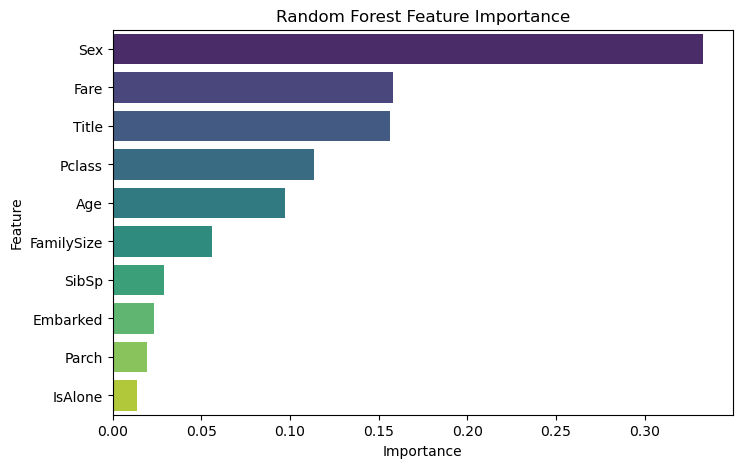

C:\Users\jinda\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:49:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


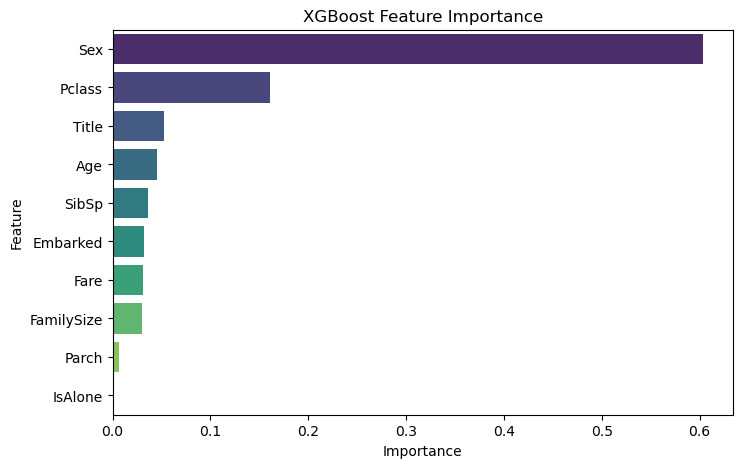

In [13]:
def plot_feature_importance(model, model_name, features):
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        "Feature": features,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="viridis")
    plt.title(f"{model_name} Feature Importance")
    plt.show()

# Random Forest
plot_feature_importance(rf.fit(X_train, y_train), "Random Forest", X.columns)

# XGBoost
plot_feature_importance(xgb.fit(X_train, y_train), "XGBoost", X.columns)


## 9. Final Predictions
We generate predictions for the test dataset and create a Kaggle submission file.


In [14]:
final_pred = ensemble.predict(test)
output = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": final_pred
})
output.to_csv("submission.csv", index=False)
output.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
